In [1185]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft, fftfreq

# Read the file, trim out the silent part, plot it

### Read & plot the file, detect the "silent" part & cut it out:

In [1186]:
def soundclip(file, S=4000,w=1000,length=0.2,plotraw=True,plottrim=True):  
    
    (r,audio_st) = wav.read(file)
    audio1 = audio_st[:,0]                                    # convert to mono
    if plotraw==True:                                          # plot the audio waves over a time interval
        f1 = plt.figure()
        ax1 = f1.add_subplot(211)
        plt.title('Audio file')
        plt.ylabel('Amplitudes')
        plt.plot(audio1, color='m')                           
        
    t = 0                                                      
    Y = 0
    while t<(len(audio1)-w):                                   # S = volume cutoff for splicing out "silence"
        interval = abs(audio1[t:t+w])                          # w = width for test intervals
        if np.average(interval) <= S:                          # length = the length of the sound that will be kept
            t = t+w
        else:
            break
    audio = audio1[t+w:t+w+int(length*r)]                   
    file = (r,audio)
    if plottrim==True:
        f2 = plt.figure()
        ax2 = f2.add_subplot(212)
        plt.title('Audio - trimmed')
        plt.ylabel('Amplitudes')
        plt.plot(audio, color='m')
    
    plt.show()

    return(file)

In [1192]:
#print(soundclip('C major.wav', length=0.3))

In [1193]:
#print(soundclip('Ef dom7.wav', S=2000, length=0.2))

# Fourier transform

In [1194]:
import pylab
from scipy.fftpack import ifft

In [1195]:
def fftaudio(file,plotfft=True):                       # input = the output of soundclip
    (r,audio_m) = file
    audioft = fft(audio_m)                             # transform
    audioreal = abs(audioft)                           # conjugate of the complex values for plotting (amplitudes)
    audiopos = audioreal[0:int((len(audioreal)+1)/2)]  # cut out the negatives (just the opposite of the positive values so unnecessary)
    audiopos_adjust = audiopos/np.max(audiopos)        # scale the y axis to be from 0 to 1
    freq = fftfreq(len(audioreal), 1/r)                # get frequencies
                                                            # window length = length of the audio file (after trimmed)
                                                            # sample spacing = 1/rate
    freqpos = freq[0:int((len(freq)+1)/2)]             # just take the positive ones
        
    if plotfft==True:
        plt.xlabel('frequencies [Hz]')
        plt.xscale('log')
        plt.title('power (scaled to 1)')
        pylab.xlim(20, 4200)                           # 20, 4200 = range of piano frequencies
        plt.plot(freqpos, audiopos_adjust, color='g')
        
    return(freqpos, audiopos_adjust)            

In [1200]:
#fftaudio(soundclip('Ef dom7.wav', S=2000, length=0.2))
#fftaudio(soundclip('C major.wav',S=4000,length=0.3))

In [1201]:
def filteraudio(file,f_min=20,f_max=4200,S=2000,w=1000,length=0.3,plot=True):
    r,audio = soundclip(file,S,w,length,plotraw=False,plottrim=False) 
    
    powers = fft(audio)                               # transform the real data
    freq = fftfreq(audio.size,1/r)
    powers[np.abs(freq) > f_max] = 0                  # set all powers for frequencies outside (f_min,f_max) to 0
    powers[np.abs(freq) < f_min] = 0
    filtered = ifft(powers)                           # set it back into wave form
    
    fft_1 = fft(filtered)                             # take the frequency & powers for this new version
    N = audio.shape[0]     

    powers_bp = np.abs(powers[0:(N//2)])
    powers_bp_adjust = (powers_bp)/np.max(powers_bp)
    
    if plot==True:
        fig=plt.figure(figsize=(10,5))

        ax=plt.subplot(211)
        ax.plot(audio, color='m',label='original waveform')
        ax.plot(filtered, color='b', label='filtered waveform')

        ax=plt.subplot(212)       
        pylab.xlim(f_min, f_max) 
        ax.plot(freq[0:int(len(freq)//2)],powers_bp_adjust, color='b', label='filtered frequency spectrum')
        
        plt.show()
    
    return(freq[0:int(len(freq)//2)],powers_bp_adjust)

The filter function allows user-inputted cutoffs for frequencies to help filter the fourier transform (from sound in the environment as well as some harmonics) before taking relevant frequencies. When setting the frequency range to be between C3 and C5 for a C major chord played all in octave 4, you can see where some slightly flat frequencies for the harmonic C5 (C4 is in the chord, and C5 is showing up as a harmonic) start to pop up. When the frequency range is expanded to the octave below and the octave above the range in which the notes were played, harmonics for each note in the next octave pop up.

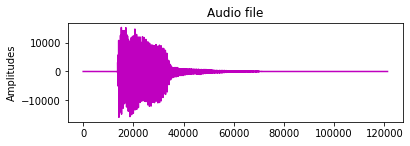

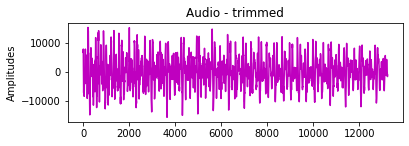

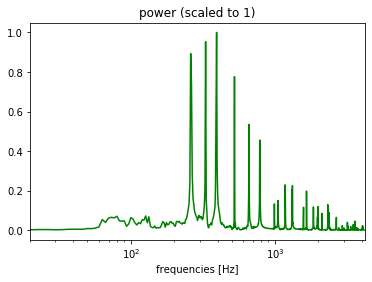

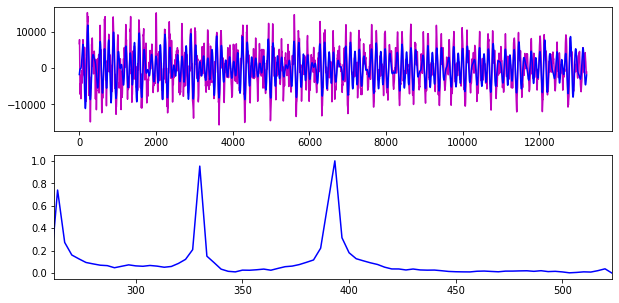

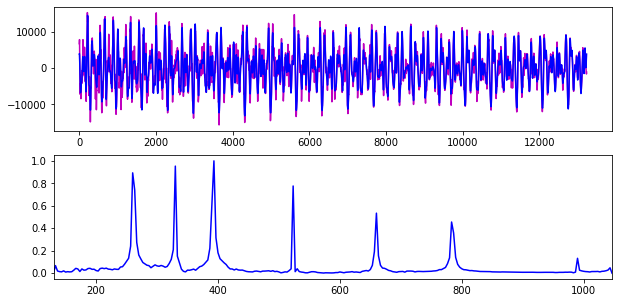

(array([0.00000000e+00, 3.33333333e+00, 6.66666667e+00, ...,
        2.20400000e+04, 2.20433333e+04, 2.20466667e+04]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [1202]:
fftaudio(soundclip('C major.wav',S=4000,length=0.3))
filteraudio('C major.wav',f_min=261.63,f_max=523.25,S=4000,w=1000,length=0.3,plot=True) # octave 4
filteraudio('C major.wav',f_min=130.81,f_max=1046.5,S=4000,w=1000,length=0.3,plot=True) # octaves 3 - 5

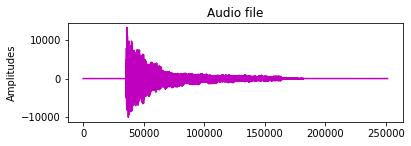

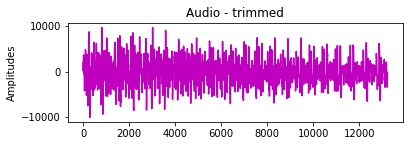

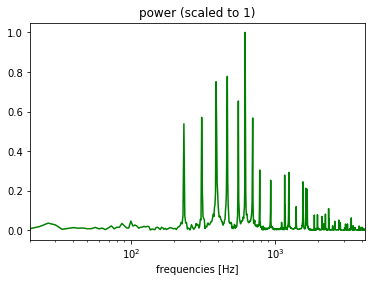

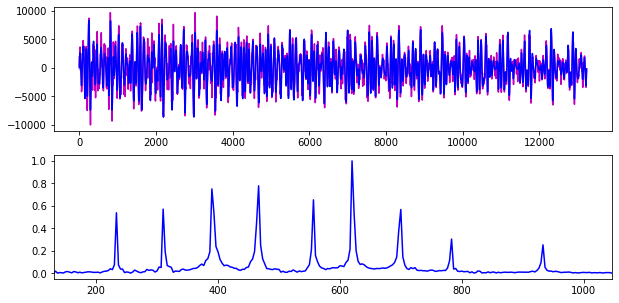

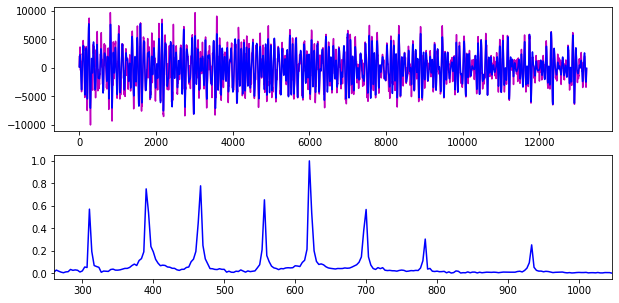

(array([0.00000000e+00, 3.33333333e+00, 6.66666667e+00, ...,
        2.20400000e+04, 2.20433333e+04, 2.20466667e+04]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [1203]:
fftaudio((soundclip('Ef dom7.wav', S=2000,w=1000,length=0.3,plotraw=True,plottrim=True)), plotfft=True)
filteraudio('Ef dom7.wav',f_min=130.81,f_max=1046.5) # octaves 3 - 5
filteraudio('Ef dom7.wav',f_min=260,f_max=1046.5) # octaves 4 & 5

# Process out the main frequencies

This step simply pulls out any relevant (i.e. "loud enough") frequencies. The C major chord actually only has 3 notes in it, but the harmonic for C4 is showing up in the output. This will get filtered out later in the "autotune" step.

In [1208]:
def cleanup(fftaudio, lim=0.6): # limit is the minimum power needed (after scaling the powers to 1) to accept the frequency
    freq = fftaudio[0]
    powers1 = fftaudio[1]
    powers = powers1/max(powers1)
    frequencies1=[]
    for i in range(0,len(freq)):                                   # take all frequencies with power above the limit
        if powers[i] > lim:
            frequencies1.append(freq[i])
    
    frequencies=[frequencies1[0]]
    for j in range(1,len(frequencies1)):                           # there may be a small range of frequencies for the same note (ex. 260, 263)
        if frequencies1[j]-frequencies[len(frequencies)-1] > 5:    # so this removes potential "repeats"
            frequencies.append(frequencies1[j])

    return(frequencies)

In [1209]:
filteroutput1 = filteraudio('C major.wav',f_min=260,f_max=1046.5,S=4000,w=1000,length=0.3,plot=False) # octaves 4 & 5
cleanup(filteroutput1)

[260.0, 330.0, 390.0, 523.3333333333334]

In [1210]:
filteroutput2 = filteraudio('Ef dom7.wav',f_min=260,f_max=1046.5,S=2000,w=1000,length=0.3,plot=False) # octaves 4 & 5
cleanup(filteroutput2)

[390.0, 466.6666666666667, 556.6666666666667, 620.0]

# Return the frequencies as notes (i.e. 440 --> A)

### Some sets that will get used a bunch:
* Notes = each note in octave 4, listed by its name, frequency, and numerical position in the scale
* letters, fs, and nums are just each such component of Notes

In [701]:
Notes = [["C",261.63,1],["C#",277.18,2],["D",293.66,3],["Eb",311.13,4],["E",329.63,5],["F",349.23,6],["F#",369.99,7],["G",392,8],["Ab",415.3,9],["A",440,10],["Bb",466.16,11],["B",493.88,0]]
letters = [i[0] for i in Notes]
fs = [float(i[1]) for i in Notes]
nums = [i[2] for i in Notes]

### Set all frequencies to be in octave 4, then match them to their correctly-tuned frequency

In [1211]:
from matplotlib import colors

def plotchord(autotune_notes):
    height = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    notheight = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    tones = ('C','C#','D','D#','E','F','F#','G','G#','A','A#','B','C.','C#.','D.','D#.','E.','F.','F#.','G.','G#.','A.','A#.','B.')
    for i in autotune_notes:
        height[i[2]-1]=1
        height[i[2]+11]=1
        notheight[i[2]-1]=0
        notheight[i[2]+11]=0
    plt.figure(figsize=(15,3))
    plt.bar(tones, height, color='m')
    plt.bar(tones, notheight, color='k')
    plt.xticks(tones, tones)
    plt.yticks(height,height)

    plt.show()

#plotchord([['A', 440, 10], ['C', 261.63, 1], ['E', 329.63, 5]])

In [1212]:
fs_edge = [254.28]
for i in fs:
    fs_edge.append(i)
fs_edge.append(509)

def autotune(frequencies,plot=True): # brings every frequency to its corresponding note in octave 4 
    octave4 = []
    #octs=[]
    for f in frequencies:
        octave=4
        if f < 254.28365:
            while f < 254.28365:
                f = 2*f
                #octave -= 1
        if f >= 508.5672:
            while f > 508.5672:
                f = 0.5*f
                #octave += 1
        if 254.28365 <= f < 508.5672:
            octave4.append(f)
            #octs.append(octave)
    
    # filters out potential "repeats" from multiple octaves having been present before
    # matches each frequency to its closest note & corresponding frequency 
    autotune_notes = []
    for f in octave4:   
        for j in range(1,13):
            if (f > (np.average([fs_edge[j],fs_edge[j-1]]))) and (f < (np.average([fs_edge[j],fs_edge[j+1]]))):
                for i in range(0,len(autotune_notes)):
                    if nums[j-1] == autotune_notes[i][2]:
                        break
                else:
                    autotune_notes.append(Notes[j-1])
    
    if plot==True:
        plotchord(autotune_notes)
    
    return(autotune_notes)

#### In this test input, the frequencies are in different octaves, slightly out of tune, and A appears twice (A3 and A4). The function puts everything into octave 4 for computing ease, gets rid of the second A, and assigns the correct frequency to each note.

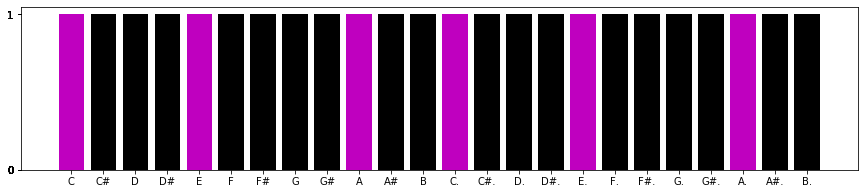

[['A', 440, 10], ['C', 261.63, 1], ['E', 329.63, 5]]


In [1213]:
test = np.array([220, 265, 330, 440]) # A, C, & E that are slightly off, different octaves (A3,C4,G4)
auto_test = autotune(test)
print(auto_test)

#### Testing out the inputted audio samples:

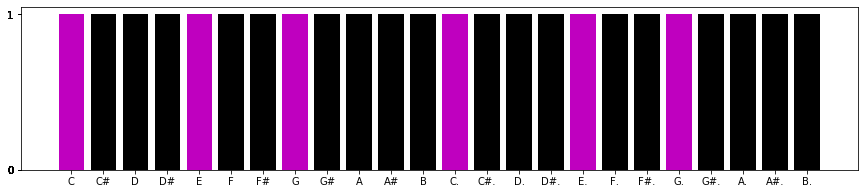

[['C', 261.63, 1], ['E', 329.63, 5], ['G', 392, 8]]

In [1214]:
CMoutput = filteraudio('C major.wav',f_min=261.63,f_max=523.25,S=4000,w=1000,length=0.3,plot=False)
CMfrequencies = cleanup(CMoutput)
autotune(CMfrequencies)

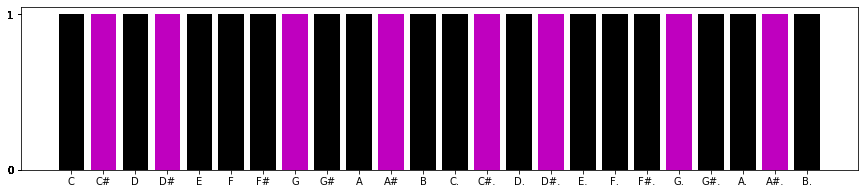

[['G', 392, 8], ['Bb', 466.16, 11], ['C#', 277.18, 2], ['Eb', 311.13, 4]]

In [1215]:
Efoutput = filteraudio('Ef dom7.wav',f_min=130,f_max=1046,S=2000,w=1000,length=0.3,plot=False)
Effrequencies = cleanup(Efoutput)
autotune(Effrequencies)

# Determine what the chord is & print out its name + notes

#### Using the 9 common chord types:

* Major triad (0,4,7)
* Minor triad (0,3,7)
* Diminished (0,3,6)
* Major seventh (0,4,7,11)
* Minor Seventh (0,3,7,10)
* Dominant Seventh (0,4,7,10)
* Suspended ( sus2 (0,2,7) / sus4 (0,5,7) ) --> a sus2 chord = a sus4 chord built on its fifth, so will refer to as sus4
* Augmented (0,4,8) --> inverting gives the augmented chord for each note, so will refer to by an arbitrary note
* Can check inversion but will be squishing everything into octave 4

#### A couple test chords

In [1302]:
# 1st inv
A_minor7 = autotune((261.63, 329.63, 392, 440),plot=False)
print(A_minor7)

# 2nd inv G sus4, root C sus2
G_sus4 = autotune((294,390,520),plot=False)
print(G_sus4)

# root
C_M = autotune(CMfrequencies,plot=False)
print(C_M)

# 1st inv
Ef_dom7 = autotune(Effrequencies,plot=False)
print(Ef_dom7)

# augmented so all three are true
A_aug = autotune((440,277,350),plot=False)
print(A_aug)

[['C', 261.63, 1], ['E', 329.63, 5], ['G', 392, 8], ['A', 440, 10]]
[['D', 293.66, 3], ['G', 392, 8], ['C', 261.63, 1]]
[['C', 261.63, 1], ['E', 329.63, 5], ['G', 392, 8]]
[['G', 392, 8], ['Bb', 466.16, 11], ['C#', 277.18, 2], ['Eb', 311.13, 4]]
[['A', 440, 10], ['C#', 277.18, 2], ['F', 349.23, 6]]


### Take the main frequencies as found in the autotune function, print the name/type of chord it makes
* Ignoring inversion (having put everything into octave 4)

In [1313]:
def notes_chord(autotune_notes):           # takes the collection of notes and matches it to the chord it is
    nums = [i[2] for i in autotune_notes]
    for i in nums:                         # there's only 1 chord but don't know which one would be the root after "squishing" them so have to try each configuration
        chord_i1 = [(j-i)%12 for j in nums]       # mod 12
        chord_i1.sort()                           # put in numerical order --> this gives the spaces between each note with reference to the first one
        chord_nums = [(j+i)%12 for j in chord_i1] # adding i back, mod 12, gives the OG notes but in the right order
        chord_letters = [letters[i-1] for i in chord_nums]
        
        if len(chord_i1) == 3:
            chord_i = np.append(chord_i1,0)
        if len(chord_i1) == 4:
            chord_i = chord_i1
                
        if chord_i[1]==5 and chord_i[2]==7 and chord_i[3]==0:
            array=(chord_nums,chord_letters,"suspended(4)")
            print("{} sus4" .format(letters[chord_nums[0]-1]))
        if chord_i[1]==3:
            if chord_i[2] == 7 and chord_i[3] == 0:
                print("{} minor" .format(letters[chord_nums[0]-1]))
                array=(chord_nums,chord_letters, "minor")
            if chord_i[2] == 6 and chord_i[3] == 0:
                print("{} diminished" .format(letters[chord_nums[0]-1]))
                array=(chord_nums,chord_letters, "diminished")
            if chord_i[2] == 7 and chord_i[3] == 10:
                print("{} minor seventh" .format(letters[chord_nums[0]-1]))
                array=(chord_nums,chord_letters, "minor seventh")
        if chord_i[1] == 4:
            if chord_i[2] == 7 and chord_i[3] == 0:
                print("{} major" .format(letters[chord_nums[0]-1]))
                array=(chord_nums,chord_letters, "major")
            if chord_i[2] == 7 and chord_i[3] == 11:
                print("{} major seventh" .format(letters[chord_nums[0]-1]))
                array=(chord_nums,chord_letters, "major seventh")
            if chord_i[2] == 7 and chord_i[3] == 10:
                print("{} dominant seventh" .format(letters[chord_nums[0]-1]))
                array=(chord_nums,chord_letters, "dominant seventh")
            if chord_i[2] == 8 and chord_i[3] == 0:
                print("Augmented")
                print("no standard major or minor key contains all three notes")
                array=(chord_nums,chord_letters, "augmented")
                break
    
    return(array)

In [1312]:
# testing it out:
print(notes_chord(A_minor7))
print(notes_chord(G_sus4))
print(notes_chord(Ef_dom7))
print(notes_chord(C_M))
print(notes_chord(A_aug))

A minor seventh
([10, 1, 5, 8], ['A', 'C', 'E', 'G'], 'minor seventh')
G sus4
([8, 1, 3], ['G', 'C', 'D'], 'suspended(4)')
Eb dominant seventh
([4, 8, 11, 2], ['Eb', 'G', 'Bb', 'C#'], 'dominant seventh')
C major
([1, 5, 8], ['C', 'E', 'G'], 'major')
augmented
no standard major or minor key contains all three notes
([10, 2, 6], ['A', 'C#', 'F'], 'augmented')


# Picking the keys that fit

* “elimination round” sort of function that checks which keys have the first note, and then of those remaining, checks which have the second, etc.
* just using major & natural minor keys
* the numbers, for each output, indicate which note the root of the chord is in the scale for that given key. (i.e. any G chord is on the 1 for G major or minor, is on the 5 for C major or minor, etc.)
* the 1 or 0 on the end indicates whether the key is major or minor. Not sure I'll need this, but figured I'd stick a number representation of it somewhere just in case

In [1221]:
Cn_an = [1,3,5,6,8,10,12]

([1, 5, 8], ['C', 'E', 'G'], 'major')

def findmykeys(notes_chord,keytype):
    majorkeys=[]
    minorkeys=[]
    tonics = np.arange(1,13)
    for i in notes_chord[0]: 
        for j in tonics:
            key_j = [(j+n-1)%12 for n in Cn_an] # check which major keys contain i (j=1 --> C, j=12 --> B)
            if i not in key_j: # if the key doesn't contains i it gets set to 0
                tonics[j-1]=0
    for j in tonics:
        l = letters[j-1]
        m = letters[((j+9)%12 - 1)]
        if j > 0:
            majorkeys.append(("{} major" .format(l),j,1))
            minorkeys.append(("{} minor" .format(m),(j+9)%12,0))
    if keytype=="major":
        return(majorkeys)
    if keytype=="minor":
        return(minorkeys)

In [1224]:
findmykeys(notes_chord(G_sus4),keytype="major")

G sus4


[('C major', 1, 1),
 ('Eb major', 4, 1),
 ('F major', 6, 1),
 ('G major', 8, 1),
 ('Bb major', 11, 1)]

In [1225]:
findmykeys(notes_chord(A_minor7),keytype="minor")

A minor seventh


[('A minor', 10, 0), ('D minor', 3, 0), ('E minor', 5, 0)]

In [1306]:
findmykeys(notes_chord(A_aug),keytype="major") # no key contains all three notes of an augmented chord so this works

A augmented
C# augmented
F augmented


[]

# For each key, determine where in the key that chord fits

* a chord relative to a key just becomes a matter of numerical difference.
* For example, if the key is C major and the chord is G major, the key's tonic is C=1. The notes are G=8, B=12 and D=3. So the chord, relative to C major, is defined as the notes that have a "difference" of 7, 11, and 2 half-steps from the tonic, in other words the V chord (though I'm realizing this means if the key has something like B=12 as its tonic, then C=1 would be a difference of 1, so mod12 is going to come into play here).


In [1226]:
def lockinkey(notes_chord,keytype): # for each key, determine where the chord "locks" in #yaypuns
    keys=findmykeys(notes_chord,keytype)
    notes = notes_chord[0]
    name = notes_chord[2]
    lockinkey=[]
    keynums=[]
    for key in keys:
        incontext = []
        for note in notes:
            incontext.append((note - key[1])%12)
        if incontext[0]==0:
            print(key[0],'1', name)
            keynums.append((key[1],key[2],'1',name))
        if incontext[0]==2:
            print(key[0],'2', name)
            keynums.append((key[1],key[2],'2',name))
        if (key[2]==1 and incontext[0]==4) or (key[2]==0 and incontext[0]==3):
            print(key[0],'3', name)
            keynums.append((key[1],key[2],'3',name))
        if incontext[0]==5:
            print(key[0],'4', name)
            keynums.append((key[1],key[2],'4',name))
        if incontext[0]==7:
            print(key[0],'5', name)
            keynums.append((key[1],key[2],'5',name))
        if incontext[0]==9:
            print(key[0],'6', name)
            keynums.append((key[1],key[2],'6',name))
        if (key[2]==1 and incontext[0]==11) or (key[2]==0 and incontext[0]==10):
            print(key[0],'7', name)
            keynums.append((key[1],key[2],'7',name))
    return(notes[0],keynums)

In [1227]:
#lockinkey(notes_chord(G_sus4),"major")
lockinkey(([1, 5, 8], ['C', 'E', 'G'], 'major'), "major")

C major 1 major
F major 5 major
G major 4 major


(1, [(1, 1, '1', 'major'), (6, 1, '5', 'major'), (8, 1, '4', 'major')])

# Hear that chord fit into each key:

* Once the function spits out what chords were inputted & all the different ways it can function in different keys, the following function is a way to hear the outcome, inputting the results just given to hear playback of the standard root major/minor chord for the key, followed by the (autotuned, un-inverted) chord, back to the root
* because everything's in octave 4, the chords actually are getting inverted for playback - still, the idea of hearing how the same set of notes can have extremely different functions depending on the key comes across

In [1228]:
import math
import pyaudio

In [1236]:
quiet = AudioSegment.from_file("quiet.wav")

fifths = [
    AudioSegment.from_file("CC.wav"),  
    AudioSegment.from_file("CS.wav"), 
    AudioSegment.from_file("DD.wav"),    
    AudioSegment.from_file("DS-Ef.wav"), 
    AudioSegment.from_file("EE.wav"), 
    AudioSegment.from_file("FF.wav"),   
    AudioSegment.from_file("FS.wav"),
    AudioSegment.from_file("GG.wav"),  
    AudioSegment.from_file("GS.wav"),
    AudioSegment.from_file("AA.wav"),   
    AudioSegment.from_file("BF.wav"),
    AudioSegment.from_file("BB.wav"),   
]

thirds = [
    AudioSegment.from_file("C234.wav"),   
    AudioSegment.from_file("Cs234.wav"), 
    AudioSegment.from_file("D234.wav"),     
    AudioSegment.from_file("Ds234.wav"),    
    AudioSegment.from_file("E345.wav"),   
    AudioSegment.from_file("F345.wav"),    
    AudioSegment.from_file("Fs345.wav"),
    AudioSegment.from_file("G345.wav"),    
    AudioSegment.from_file("Gs2345.wav"),
    AudioSegment.from_file("A2345.wav"),     
    AudioSegment.from_file("Bf2345.wav"),
    AudioSegment.from_file("B234.wav"),         
]

scale = [
    AudioSegment.from_file("C.wav"),
    AudioSegment.from_file("Cs-Df.wav"),
    AudioSegment.from_file("D.wav"),
    AudioSegment.from_file("Ds-Ef.wav"),
    AudioSegment.from_file("E.wav"),
    AudioSegment.from_file("F.wav"),
    AudioSegment.from_file("Fs-Gf.wav"),
    AudioSegment.from_file("G.wav"),
    AudioSegment.from_file("Gs-Af.wav"),
    AudioSegment.from_file("A.wav"),
    AudioSegment.from_file("As-Bf.wav"),
    AudioSegment.from_file("B.wav")
]

oct34 = [
    AudioSegment.from_file("3C.wav"),     # C = 0,12
    AudioSegment.from_file("3Cs-Df.wav"), 
    AudioSegment.from_file("3D.wav"),     # D = 2,14
    AudioSegment.from_file("3Ds-Ef.wav"), # 
    AudioSegment.from_file("3E.wav"),     # E = 4
    AudioSegment.from_file("3F.wav"),     # F = 5
    AudioSegment.from_file("3Fs-Gf.wav"),
    AudioSegment.from_file("3G.wav"),     # G = 7
    AudioSegment.from_file("3Gs-Af.wav"),
    AudioSegment.from_file("3A.wav"),     # A = 9
    AudioSegment.from_file("3As-Bf.wav"),
    AudioSegment.from_file("3B.wav"),     # B = 11,23
    AudioSegment.from_file("4C.wav"),     
    AudioSegment.from_file("4Cs-Df.wav"),
    AudioSegment.from_file("4D.wav"),     
    AudioSegment.from_file("4Ds-Ef.wav"),
    AudioSegment.from_file("4E.wav"),     
    AudioSegment.from_file("4F.wav"),     
    AudioSegment.from_file("4Fs-Gf.wav"),
    AudioSegment.from_file("4G.wav"),     
    AudioSegment.from_file("4Gs-Af.wav"),
    AudioSegment.from_file("4A.wav"),     
    AudioSegment.from_file("4As-Bf.wav"),
    AudioSegment.from_file("4B.wav")      
]



In [1230]:
def keychord(do,Mm): 
    rootfifth = fifths[do-1]
    third = thirds[(do+2+Mm)%12]
    chord = third.overlay(rootfifth)
    play(chord)   

#keychord(1,1) # --> C E G --> 0 4 7
#keychord(12,0) # --> B D Fs --> 11 2 6

In [1272]:
def constructchord(chordnum,chordtype):                          
    i = chordnum-1
    if chordtype == "major":
        chord4 = quiet
        chord3 = oct34[(i+7)%12+12]
        chord2 = oct34[(i+7)%12+9]
        chord1 = oct34[(i+7)%12+5] # A C# E --> 9 1 4 // 21 13 16 --> 16, 13, 9
    if chordtype == "minor":
        chord4 = quiet
        chord3 = oct34[(i+7)%12+12]
        chord2 = oct34[(i+7)%12+8]
        chord1 = oct34[(i+7)%12+5]
    if chordtype == "majorseventh":
        chord4 = oct34[(i+11)%12+12] # C E G B --> 0 4 7 11 // 12 16 19 23 --> 23, 19, 16, 12
        chord3 = oct34[(i+11)%12+8]
        chord2 = oct34[(i+11)%12+5]
        chord1 = oct34[(i+11)%12+1]
    if chordtype == "minorseventh":
        chord4 = oct34[(i+10)%12+12] # C Ef G Bf --> 0 3 7 10 // 12 15 19 22 --> 22, 19, 15, 12
        chord3 = oct34[(i+10)%12+9]
        chord2 = oct34[(i+10)%12+5]
        chord1 = oct34[(i+10)%12+2]
    if chordtype == "suspended(4)":
        chord4 = quiet               # C F G --> 0 5 7 // 12 17 19 --> 19, 17, 12
        chord2 = oct34[(i+7)%12+12]
        chord3 = oct34[(i+7)%12+10]
        chord1 = oct34[(i+7)%12+5]
    if chordtype == "augmented":
        chord4 = quiet               # C E G# --> 0 4 8 // 12 16 20 --> 20,16,12
        chord2 = oct34[(i+8)%12+12]
        chord3 = oct34[(i+8)%12+8]
        chord1 = oct34[(i+8)%12+4]
    if chordtype == "diminished":
        chord4 = quiet               # C Ef F# --> 0 3 6 // 12 15 18 --> 18,15,12
        chord2 = oct34[(i+6)%12+12]
        chord3 = oct34[(i+6)%12+9]
        chord1 = oct34[(i+6)%12+6]
    if chordtype == "dominant seventh":
        chord4 = oct34[(i+10)%12+12] # C E G Bf --> 0 4 7 10 // 12 16 19 22 --> 22, 19, 16, 12
        chord3 = oct34[(i+10)%12+9]
        chord2 = oct34[(i+10)%12+6]
        chord1 = oct34[(i+10)%12+2]
    
    chord_1 = chord1.overlay(chord2)
    chord_2 = chord3.overlay(chord4)
    chord = chord_1.overlay(chord_2)
    play(chord)    

In [1275]:
def playback(lockinkey,keytype,Mm):
    for key in lockinkey[1]: 
        print(letters[key[0]-1], keytype, key[2])
        keychord(key[0],Mm)
        constructchord(lockinkey[0],lockinkey[1][0][3])
        keychord(key[0],Mm)

In [1276]:
#constructchord(1,'dominant seventh')

# Bringing it all together in one function

#### And now all the functions are in place to be combined! This function does the following:

##### "Mm"
* Just encodes whether the user wants a major or minor key as a number, will get used in constructing chords for playback

##### Filefilter
* reads audio file, converts it to mono, & plots this audio data
* cuts out any quiet parts at the beginning of the recording to trim the audio to a user-inputted length (in the examples, around 0.3 seconds - the chords used here were from an electronic keyboard that was pretty quick to quiet down)
* uses fourier transforms (fft) to see the frequency distribution & scales these powers to (0,1)
* using a user-inputted range of frequencies, cuts out any other frequencies not in this range & re-runs the audio data & frequency distribution 

##### Frequencies
* pinpoints the frequencies above a certain threshold (around 0.6 tended to work well)
* puts all frequencies into the same octave so that any combination of the same objective notes will return the same chord (simplifies for octaves & undoes any inversion to get at the most baseline chord
* cuts out any repeated frequencies (aka frequencies that are slightly different but represent the same note, like 440 and 442)
* returns these main frequencies present in the data (repetitions for octaves may still be present, though)

##### Notes
* tunes each frequency to its nearest exact frequency (for example, 884 Hz will be brought down an octave to 442, and then matched to A4 = 440 Hz)
* cuts out any repeats having to do with multiple octaves of the same note being initially detected

##### Chord
* identifies the chord by its type, root, & integer notation

##### Key Placement
* determines which standard major/minor keys contain all the notes in this chord
* determines the exact way this chord "fits" into each such scale 
* Example: "A minor 3 major" means "in the A minor key, this chord will function as the major triad built up from the 3rd note in the scale" whereas "C major 1 major" is saying "in C major, this chord is the standard major triad built up from the root"

##### Playback
* plays the standard triad for each key that was produced [in octaves 2 through 6 (with the tonic still lowest) to encompass the sound of the key without making its step-wise (up or down) relation to the chord relevant (i.e. the keychord is always covering notes both higher and lower than the main chord)],
* followed by the initial chord in its root form as it would be found in octaves 3-4,
* then the standard key triad again
* ...so that one can hear how the chord can function in different ways depending on which key is chosen

In [1281]:
def runitall(data,keytype="major",f_min=20,f_max=4200,S=4000,w=1000,lim=0.6,length=0.3,listen=True):
    if keytype=="major":
        Mm=1
    else:
        Mm=0
    filefilter = filteraudio(data,f_min,f_max,S,w,length) 
    frequencies = cleanup(filefilter, lim)
    notes = autotune(frequencies)
    print([i[0] for i in notes])
    chord = notes_chord(notes)
    keyplacement = lockinkey(chord,keytype)
    if listen==True:
        playback(keyplacement,keytype,Mm)

# Examples:

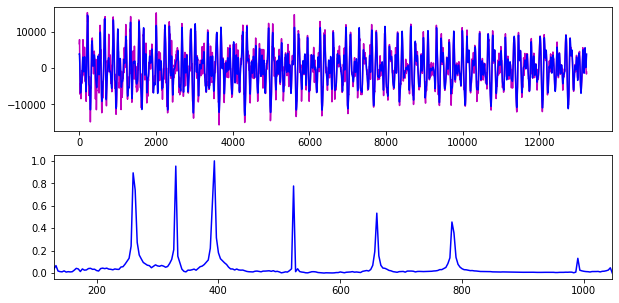

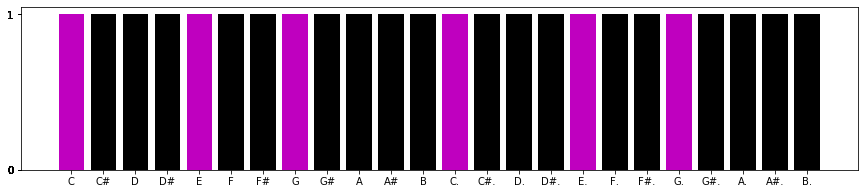

['C', 'E', 'G']
C major
C major 1 major
F major 5 major
G major 4 major
C major 1
F major 5
G major 4


In [1282]:
runitall('C major.wav',"major",f_min=130,f_max=1046,listen=True)

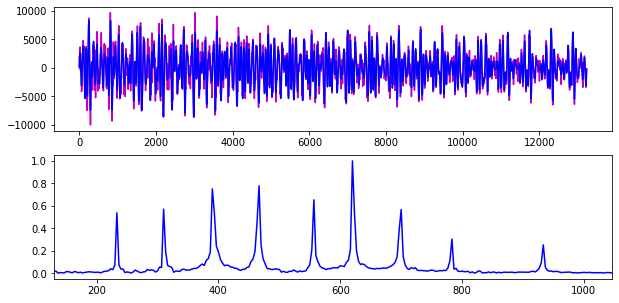

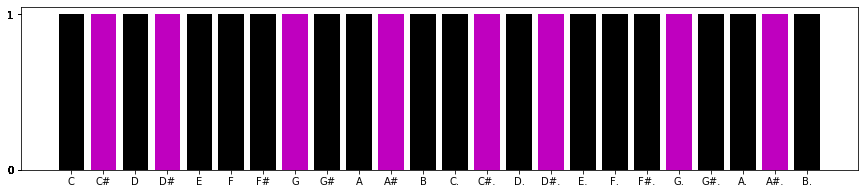

['G', 'Bb', 'C#', 'Eb']
Eb dominant seventh
F minor 7 dominant seventh
F minor 7


In [1283]:
runitall('Ef dom7.wav',keytype="minor",f_min=130,f_max=1046,S=2000,listen=True)

I made a VERY noisy audio file with "human voices" (on a keyboard) as a challenge. It works, but the limit has to be much lower to "catch" the frequencies as the other, non-relevant frequencies are still relatively noticeable, so the scaled power (scaled to 0,1) is lower for each individual frequency.

In [1343]:
original = AudioSegment.from_file("A dim.wav")
play(original)

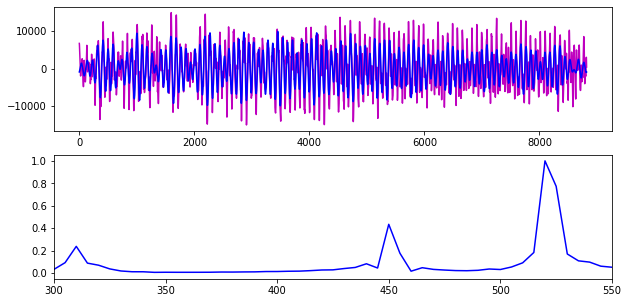

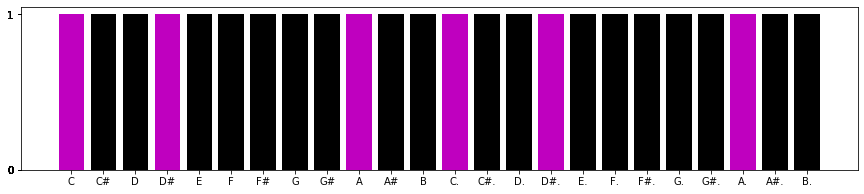

['Eb', 'A', 'C']
A diminished
Bb major 7 diminished
Bb major 7


In [1353]:
runitall('A dim.wav',keytype="major",f_min=300,f_max=550,S=4000,w=1000,lim=0.2,length=0.2,listen=True)

In [1333]:
original = AudioSegment.from_file("A dim.wav")
play(original)

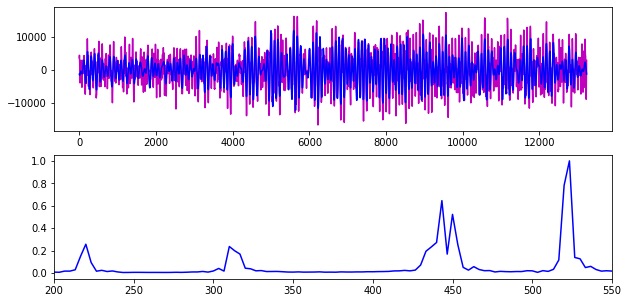

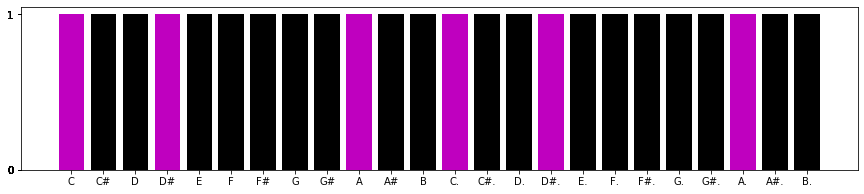

['A', 'Eb', 'C']
A diminished
Bb major 7 diminished
Bb major 7


In [1334]:
runitall('A dim.wav',keytype="major",f_min=200,f_max=550,S=3000,w=1000,lim=0.2,length=0.3,listen=True)

In [ ]:
original = AudioSegment.from_file("E sus4.wav")
play(original)

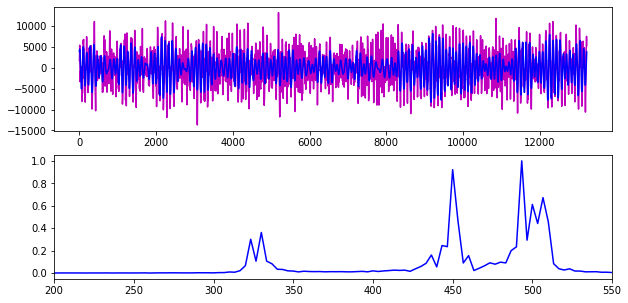

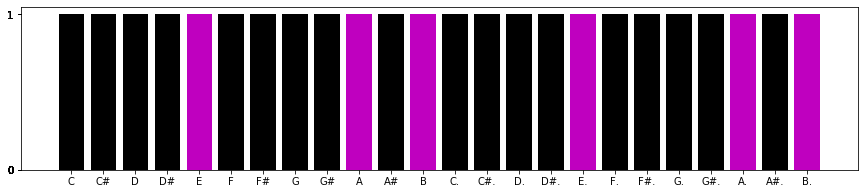

['E', 'A', 'B']
E sus4
C major 3 suspended(4)
D major 2 suspended(4)
E major 1 suspended(4)
G major 6 suspended(4)
A major 5 suspended(4)
C major 3
D major 2
E major 1
G major 6
A major 5


In [1354]:
runitall('E sus4.wav',keytype="major",f_min=200,f_max=550,S=3000,w=1000,lim=0.2,length=0.3,listen=True)